## GANs

Neste exercício aprenderemos a desenvolver uma GAN simples utilizando Keras.

Para isto, utilizaremos um dataset fictício que gera dados bidimensionais relativamente simples, e nossa rede GAN vai tentar replicar estes dados. 

Como primeiro passo, vamos criar o código para gerar este dataset e visualizar como ele se parece.

A função fictícia irá ter 2 features. A primeira (*x*) está contida no intervalo entre \[-1, 1\]. A segunda (*y*) é dependente de *x* de acordo com a equação abaixo:

<img src="https://latex.codecogs.com/svg.latex?\Large&space;y=x^2"/>

O que faremos nesse exercício é tentar treinar uma GAN para gerar ambas as variáveis de modo realístico, com apenas a informação de que 2 variáveis devem ser geradas.

Primeiro vamos criar uma função que gere instâncias <x,y> "reais"

In [1]:
!conda install keras -y

^C


In [2]:
import numpy as np

def real_function(x):
    return np.multiply(x,x)

def generate_samples(n_samples):
    result = np.zeros((n_samples,2))
    max_x,min_x = -1,+1
    x = (np.random.rand(n_samples)*(max_x-min_x)) + min_x
    result[:,0] = x
    result[:,1] = real_function(x)
    return result

training_set = generate_samples(10000)
test_set = generate_samples(10000)

training_set, training_set.shape

(array([[ 0.31393162,  0.09855306],
        [ 0.61794654,  0.38185793],
        [-0.53459628,  0.28579318],
        ...,
        [ 0.2011953 ,  0.04047955],
        [-0.69820962,  0.48749667],
        [ 0.97855539,  0.95757065]]),
 (10000, 2))

Vamos também criar uma função auxiliar para ajudar na visualização dos dados:

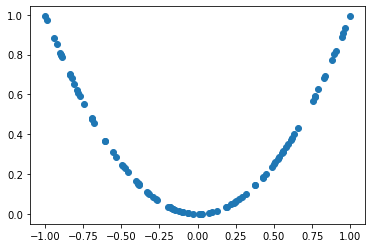

In [3]:
import matplotlib.pyplot as plt
def print_samples(data):
    plt.scatter(data[:,0], data[:, 1])
    
print_samples(training_set[:100])

Agora que temos uma base de treinamento, basta montar a nossa GAN.

Relembrando o conteúdo da aula, a GAN é composta por um *discriminador* e um *gerador*. O discriminador é um classificador comum que aprende a distinguir instâncias reais de fictícias, e o gerador tenta aprender como gerar instâncias fictícias que enganem o discriminador.

Vamos então partir para a implementação do discriminador, lembrando que a entrada é bidimensional, e a saída tem apenas uma dimensão prevendo se a instância é falsa ou verdadeira.

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def gan_discriminator_model():
    model = Sequential()
    model.add(Dense(64, input_dim=2, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = gan_discriminator_model()
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
______________________________________________________

Conforme visto na aula, o gerador é dependente do discriminador para o treinamento, e vai tentar fazer com que o discriminador erre em suas predições.

Para isto, precisamos criar um modelo *gerador* e um modelo *GAN*. O *gerador* irá partir de números aleatórios de tamanho arbitrário e tentar gerar números realísticos que sigam o padrão de nossos dados reais.

O Processo de treinamento consiste em fazer com que o discriminador falhe em sua tarefa, o que vai ser possível se o gerador criar exemplos indistinguíveis dos dados reais. Como o *gerador* necessita do *discriminador* para seu treinamento, o Keras requer criarmos um outro modelo *GAN* que vai conectar o *gerador* e *discriminador*.

Note que estamos usando a definição mais simples de custo para o gerador, o inverso do custo do discriminador.


In [5]:
input_dim = 5

def gan_generator_model(input_dim):
    model = Sequential()
    model.add(Dense(50, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Dense(32))
    model.add(LeakyReLU(0.2))
    model.add(Dense(2, activation='tanh'))
    return model

def define_gan(generator, discriminator):
    # connect generator and discriminator
    
    #O discriminador não deve ter seus pesos atualizados quando treinarmos o gerador
    discriminator.trainable = False
    ganInput = Input(shape=(input_dim,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan


generator = gan_generator_model(input_dim)
generator.summary()

gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                300       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1632      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,998
Trainable params: 1,998
Non-trainable params: 0
____________________________________________________

Agora que temos todos os modelos definidos, podemos realizar o treinamento efetivamente.

Mas antes, vamos criar algumas funções auxiliares.

A primeira `generate_batch_discriminator` vai criar um batch para treinamento do discriminador. De acordo com os valores nos parâmetros, metade do batch conterá instâncias reais (label y = 0) e metade do batch conterá instâncias falsas (label y = 1).

In [6]:
def generate_batch_discriminator(batch_size, treino = True):
    half_batch = int(batch_size/2)
    
    batch = np.zeros((batch_size, 2))
    batch_y = np.zeros(batch_size)
    
    #Pega exemplos aleatoriamente da base de treinamento ou teste
    if treino:
        random_indices = np.random.choice(len(training_set), size=half_batch, replace=False)
        batch[:half_batch, :] = training_set[random_indices, :]
    else:
        random_indices = np.random.choice(len(test_set), size=half_batch, replace=False)
        batch[:half_batch, :] = test_set[random_indices, :]
    #Labels das instâncias reais já são 0, entao nao há necessidade de mudar batch_y
    
    # A variável aleatória de entrada do gerador vai seguir uma distribuição normal
    batch[half_batch:, :] = generator.predict(np.random.normal(0, 1, size=[half_batch, input_dim]))
    batch_y[half_batch:] += 1. 
    return batch, batch_y

Precisaremos também de uma função semelhante para treinar o gerador, mas o batch de treinamento deve gerar apenas valores aleatórios, que serão alimentados ao modelo `gan`.

In [7]:
def generate_batch_gan(batch_size):
    x_gan = np.random.normal(0, 1, size=[batch_size, input_dim])
    #Neste caso criamos labels invertidos para os exemplos falsos, porque a funcao de custo
    # do gerador é o inverso do discriminador
    y_gan = np.zeros((batch_size)) 
    return x_gan,y_gan

Agora podemos criar a função de treinamento. Primeiro rodamos uma época de treinamento em batch do discriminador, para depois rodar uma época do gerador. Periódicamente visualizamos como as instâncias geradas se parecem. Durante o treinamento também iremos guardar as funcões de custo dos modelos e o percentual de acerto do discriminador em teste.

epoch: 0


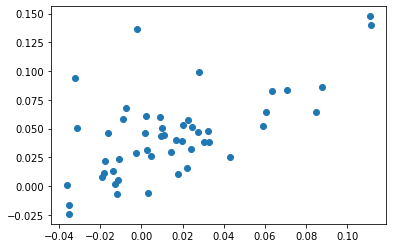

Errors Discrimin: 0.6930176019668579
Errors Generator:0.6928775310516357
Perc Discrim:0.546875
epoch: 1000


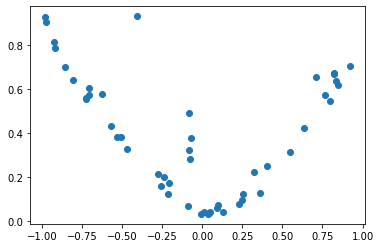

Errors Discrimin: 0.6946058869361877
Errors Generator:0.6948021650314331
Perc Discrim:0.46875
epoch: 2000


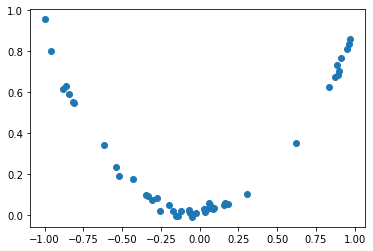

Errors Discrimin: 0.693993091583252
Errors Generator:0.6960604190826416
Perc Discrim:0.5
epoch: 3000


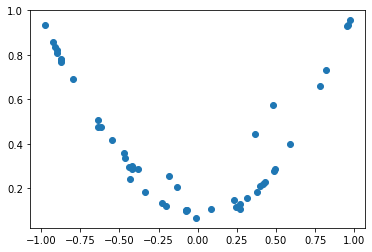

Errors Discrimin: 0.6921221017837524
Errors Generator:0.698760986328125
Perc Discrim:0.578125
epoch: 4000


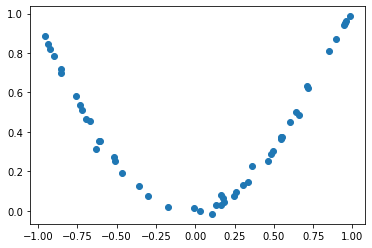

Errors Discrimin: 0.6914972066879272
Errors Generator:0.6947917342185974
Perc Discrim:0.484375
epoch: 5000


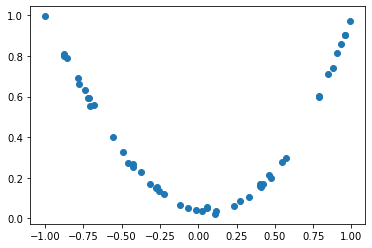

Errors Discrimin: 0.6908097267150879
Errors Generator:0.6925705075263977
Perc Discrim:0.5


In [ ]:
def print_images(samples):
    plt.close()
    print_samples(samples)
    plt.show()

batch_size = 32
epochs = 10000

test_size = 64
half_test = int(test_size /2)

#Erros do discriminador e gerador, e percentual de acerto no teste
errors_discrim = np.zeros((epochs))
errors_generator = np.zeros((epochs))
perc_discrim = np.zeros((epochs))

#Utilizado para a visualização de imagens não travar o treinamento
plt.ion()

for i in range(epochs):
    
    batch,batch_y = generate_batch_discriminator(batch_size, treino=True)       
    #Preparando o discriminador para ter seus pesos atualizados
    discriminator.trainable = True
    errors_discrim[i],_ = discriminator.train_on_batch(batch, batch_y)
    
    
    x_gan, y_gan = generate_batch_gan(batch_size)
    discriminator.trainable = False
    # update the generator via the discriminator's error
    errors_generator[i] = gan.train_on_batch(x_gan, y_gan)
    
    #Gera um batch de teste e calcula a acuracia do discriminador
    test_batch,test_y = generate_batch_discriminator(test_size, treino=False) 
   
    predictions =  (discriminator.predict(test_batch).ravel() > 0.5) * 1.
    
    perc_discrim[i] = sum(predictions == test_y)/test_size
    #periodicamente
    if i%1000 == 0:
        print("epoch: "+str(i))
        print_images(generator.predict(np.random.normal(0, 1, size=[50, input_dim])))
        print("Errors Discrimin: " + str(errors_discrim[i]))
        print("Errors Generator:" + str(errors_generator[i]))
        print("Perc Discrim:" + str(perc_discrim[i]))

Após o treinamento podemos visualizar se o treino deu certo comparando os dados reais com os gerados pela GAN.

In [ ]:
print_samples(training_set[:100,:])
print_samples(generator.predict(np.random.normal(0, 1, size=[100, input_dim])))

Também podemos visualizar os erros dos modelos e o percentual de acerto do discriminador.

In [ ]:
plt.plot(errors_generator, label='generator')
plt.plot(errors_discrim, label='discriminator')
plt.legend()

plt.figure()
plt.plot(perc_discrim)